## Updraft velocity P.D.F.s from MultiDop grids

In [294]:
import pyart
import gzip
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import dates
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import glob
import re
from copy import deepcopy
from IPython.display import Image, display
import math
from netCDF4 import Dataset
from scipy import ndimage
%matplotlib inline

Input time periods for analysis

In [313]:
# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 23
start_month = 1
start_hour = 13
start_minute = 10
start_second = 0

end_year = 2006
end_month = 1
end_day = 23
end_hour = 17
end_minute = 50
end_second = 0

data_path = '/home/rjackson/multidop_grids/'

data_path_sounding = '/home/rjackson/data/soundings/'

In [271]:
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_dda_times(start_year, start_month, start_day,
                  start_hour, start_minute, end_year,
                  end_month, end_day, end_hour, 
                  end_minute, minute_interval=5):

    start_time = datetime(start_year,
                      start_month,
                      start_day,
                      start_hour,
                      start_minute,
                      )
    end_time = datetime(end_year,
                      end_month,
                      end_day,
                      end_hour,
                      end_minute,
                      )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path +
                      'cf_compliant_grid' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-15:-3]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = '00'
             
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            0)
        time_list.append(cur_time)
        
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
           
            
            
    
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_grid_from_dda(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path +
                    'cf_compliant_grid' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = pyart.io.read_grid(file_name_str)
    return radar

In [314]:
# Plot the radars from given time.

times = get_dda_times(start_year, start_month, start_day,
                      start_hour, start_minute, end_year,
                      end_month, end_day, end_hour, 
                      end_minute, minute_interval=0)

We are about to load grid files for 1 days
Looking for files with format /home/rjackson/multidop_grids/cf_compliant_grid20060123*.nc


Get pressure as a function of height from sounding

In [211]:
# get_sounding)times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of sounding times between start_time and end_time. 
# Only 23 UTC is loaded following Pope et al. (2008)
def get_sounding_times(start_year, start_month, start_day,
                       start_hour, start_minute, end_year,
                       end_month, end_day, end_hour, 
                       end_minute, minute_interval=5):

    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )
    deltatime = end_time - start_time

    if(deltatime.seconds > 0 or deltatime.minutes > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load sounding files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time

    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_sounding +
                      'twpsondewnpnC3.b1.' +
                      year_str +
                      month_str +
                      day_str +
                      '*.'
                     '*custom.cdf')
    
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
        
   
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-26:-11]  
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
                
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []

    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
               
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_sounding(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_sounding +
                     'twpsondewnpnC3.b1.' +
                     year_str +
                     month_str +
                     day_str +
                     '.' +
                     hour_str +
                     minute_str +
                     second_str +
                     '.custom.cdf')
    sounding = Dataset(file_name_str, mode='r')
    return sounding

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [326]:
sounding_times = get_sounding_times(start_year,
                                    start_month,
                                    start_day,
                                    start_hour,
                                    start_minute, 
                                    end_year,
                                    end_month,
                                    end_day,
                                    23,
                                    59)

Sounding_netcdf = get_sounding(sounding_times[1])
num_levels = 40
p = Sounding_netcdf.variables['pres'][:]           
z = Sounding_netcdf.variables['alt'][:]

z_levels = np.arange(0.5,0.5*(num_levels+1),0.5)*1000

p_levels = np.zeros(z_levels.shape)
count = 0
for z_value in z_levels:
    index = find_nearest(z, z_value)
    p_levels[count] = p[index]
    count = count + 1

Sounding_netcdf.close()
print(p_levels)
print(z_levels)

We are about to load sounding files for 1 days
[ 946.90002441  893.79998779  844.          796.59997559  751.09997559
  707.90002441  666.59997559  627.5         590.29998779  554.70001221
  548.90002441  548.90002441  548.90002441  548.90002441  548.90002441
  548.90002441  548.90002441  548.90002441  548.90002441  548.90002441
  548.90002441  548.90002441  548.90002441  548.90002441  548.90002441
  548.90002441  548.90002441  548.90002441  548.90002441  548.90002441
  548.90002441  548.90002441  548.90002441  548.90002441  548.90002441
  548.90002441  548.90002441  548.90002441  548.90002441  548.90002441]
[   500.   1000.   1500.   2000.   2500.   3000.   3500.   4000.   4500.
   5000.   5500.   6000.   6500.   7000.   7500.   8000.   8500.   9000.
   9500.  10000.  10500.  11000.  11500.  12000.  12500.  13000.  13500.
  14000.  14500.  15000.  15500.  16000.  16500.  17000.  17500.  18000.
  18500.  19000.  19500.  20000.]


Code to get beam crossing angle (adopted from multidop (Potvin/Lang))

In [327]:
def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

Code to retrieve all vertical velocities within x degree beam crossing angle. This code uses Collis et al. (2013) definition of Deep Convective Core

In [214]:
count = 0

dc = np.ma.zeros((len(times), 81, 111))
ws = np.ma.zeros((len(times), num_levels, 81, 111))
ws_all = np.ma.zeros((len(times), num_levels, 81, 111))
rfs = np.ma.zeros((len(times), num_levels, 81, 111))

for time in times:
    pyart_grid = get_grid_from_dda(time)
    bca = get_bca(pyart_grid)
    w = pyart_grid.fields['upward_air_velocity']['data']
    updraft_depth = np.zeros(w[0].shape)
    z = pyart_grid.fields['reflectivity']['data']
    for levels in range(0,num_levels-1):
        w[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                                   bca > 5*math.pi/6), 
                                                     z[levels] < 1), w[levels])

        is_in_updraft = w[levels] > 1
        is_in_updraft_next = w[levels+1] > 1
        both_in_updraft = np.logical_or(np.logical_and(is_in_updraft,
                                                       is_in_updraft_next),
                                        updraft_depth > 10)
        

        add_one = np.where(both_in_updraft)
        set_to_zero = np.where(~both_in_updraft)
        if(len(add_one[0]) > 0):
            updraft_depth[add_one[0], add_one[1]] = updraft_depth[add_one[0], 
                                                                  add_one[1]] + 1 
            updraft_depth[set_to_zero[0], set_to_zero[1]] = 0       
    
    dc[count] = updraft_depth
    ws[count] = w
    ws_all[count] = w
    rfs[count] = z
    count = count + 1

# Calculate PDF
mean_w = np.ma.zeros(num_levels)
median_w = np.ma.zeros(num_levels)
ninety_w = np.ma.zeros(num_levels)
ninety_five_w = np.ma.zeros(num_levels)
ninety_nine_w = np.ma.zeros(num_levels)
mean_z = np.ma.zeros(num_levels)
median_z = np.ma.zeros(num_levels)
ninety_z = np.ma.zeros(num_levels)
ninety_five_z = np.ma.zeros(num_levels)
ninety_nine_z = np.ma.zeros(num_levels)
dims = ws.shape
bins = np.arange(-10,40,1)
bins_z = np.arange(0,60,1)
w_hist = np.ma.zeros((num_levels, len(bins)-1))
w_cfad = np.ma.zeros((num_levels, len(bins)-1))
z_hist = np.ma.zeros((num_levels, len(bins_z)-1))

for levels in range(0,num_levels):
    w_level = ws[:,levels,:,:]
    r_level = rfs[:,levels,:,:]
    for i in range(0, dims[0]):
        w_level[i,:,:] = np.ma.masked_where(np.logical_or(dc[i,:,:] < 10,
                                                          r_level[i,:,:] < 1),
                                                          w_level[i,:,:])
        
    
    ws_in_core = w_level[~w_level.mask]
    zs_in_core = r_level[~w_level.mask]
    mean_w[levels] = np.ma.mean(ws_in_core)
    median_w[levels] = np.ma.median(ws_in_core)
    mean_z[levels] = np.ma.mean(zs_in_core)
    median_z[levels] = np.ma.median(zs_in_core)
    counts, bins = np.histogram(ws_in_core, bins=bins)
    w_hist[levels] = counts
    w_cfad[levels] = counts/(sum(counts)*0.5*1)
    counts_z, bins_z = np.histogram(zs_in_core, bins=bins_z)  
    z_hist[levels] = counts_z/(sum(counts_z)*0.5*1)
    total_counts = total_counts + sum(counts)
    
    if(len(ws_in_core) > 0):
        ninety_z[levels] = np.percentile(zs_in_core, 90)
        ninety_five_z[levels] = np.percentile(zs_in_core, 95)
        ninety_nine_z[levels] = np.percentile(zs_in_core, 99)
        ninety_w[levels] = np.percentile(ws_in_core, 90)
        ninety_five_w[levels] = np.percentile(ws_in_core, 95)
        ninety_nine_w[levels] = np.percentile(ws_in_core, 99)
    else:
        ninety_w[levels] = float('nan')
        ninety_five_w[levels] = float('nan')
        ninety_nine_w[levels] = float('nan')
        ninety_five_z[levels] = float('nan')
        ninety_nine_z[levels] = float('nan')
        ninety_z[levels] = float('nan')  

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/rjackson/anaconda3/lib/python3.5/si

## Varble et al. (2014) defintion of convective core 

Uses continous regions > 1 m s-1, rather than columns, to define DCC. This generates p.d.f.s of reflectivity and vertical velocity.

In [331]:
ws = np.ma.zeros((len(times), num_levels, 81, 111))
ws_all = np.ma.zeros((len(times), num_levels, 81, 111))
minzs = np.ma.zeros((len(times), num_levels, 81, 111))
maxzs = np.ma.zeros((len(times), num_levels, 81, 111))
Zs = np.ma.zeros((len(times), num_levels, 81, 111))
max_w_individual = []
level_individual = []
count = 0
n = 0
for time in times:
    ## Get all continous regions of W > 1 m s-1 in 3D w array
    pyart_grid = get_grid_from_dda(time)
    bca = get_bca(pyart_grid)
    w = pyart_grid.fields['upward_air_velocity']['data']
    Z = pyart_grid.fields['reflectivity']['data']
    w_all = deepcopy(w)
    for levels in range(0,num_levels-1):
        w[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                                   bca > 5*math.pi/6), 
                                                     w[levels] < 1), w[levels])
        Z[levels] = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                                   bca > 5*math.pi/6), 
                                                     w[levels] < 1), Z[levels])
        w_all[levels] = np.ma.masked_where(np.logical_or(bca < math.pi/6,
                                                         bca > 5*math.pi/6), 
                                                         w_all[levels])

    grid_x = pyart_grid.point_x['data']
    grid_y = pyart_grid.point_y['data']
    grid_z = pyart_grid.point_z['data']
    
    # Set mask to exclude data outside of updrafts
    w_temp = deepcopy(w)
    w_temp[~w_temp.mask] = 1
    w_temp[w_temp.mask] = 0
    w_temp.mask = False

    six_connected_structure = [[[0,0,0],
                                [0,1,0],
                                [0,0,0]],
                               [[0,1,0],
                                [1,1,1],
                                [0,1,0]],
                               [[0,0,0],
                                [0,1,0],
                                [0,0,0]]]

    updrafts, num_updrafts = ndimage.measurements.label(w_temp, 
                                                        structure=six_connected_structure)
    
    # Get statistics in continous regions
    index=np.arange(0, num_updrafts + 1)
    max_z = ndimage.measurements.maximum(grid_z, 
                                         labels=updrafts, 
                                         index=index)
    min_z = ndimage.measurements.minimum(grid_z, 
                                         labels=updrafts,
                                         index=index)
   
    deep_cores = np.where(np.logical_and(max_z >= 15000, min_z <= 1000))
    depth = max_z-min_z

    max_z_olevel = np.ma.zeros((81,111))
    min_z_olevel = np.ma.zeros((81,111))
    max_z_level = np.ma.zeros((num_levels, 81,111))
    min_z_level = np.ma.zeros((num_levels, 81,111))
    
    # Find deep convective cores and get max updraft speeds
    for levels in range(0,num_levels-1):
        label_level = updrafts[levels]
        masked_array = np.ma.zeros(updrafts.shape)
        masked_array.mask = True
        w_temp = w[levels]
        
        for labels in range(1, len(max_z)-1):
            indicies = np.ma.where(label_level == labels)                                
            max_z_olevel[indicies] = max_z[labels]
            min_z_olevel[indicies] = min_z[labels]
            
            if(len(indicies[0]) > 0  
               and max_z[labels] >= 15000
               and min_z[labels] <= 1000):
                max_w_individual.append(max(w_temp[indicies]))
                level_individual.append(levels)
                n = n + 1

        max_z_level[levels] = max_z_olevel
        min_z_level[levels] = min_z_olevel
        

    ws[count] = w
    ws_all[count] = w_all
    minzs[count] = min_z_level
    maxzs[count] = max_z_level 
    Zs[count] = Z
    count = count + 1


max_w_individual = np.array(max_w_individual)
level_individual = np.array(level_individual)
print(str(len(max_w_individual[level_individual == 1])) + ' DCCs found')

# Calculate PDF
mean_w = np.ma.zeros(num_levels)
median_w = np.ma.zeros(num_levels)
max_w = np.ma.zeros(num_levels)
mean_z = np.ma.zeros(num_levels)
median_z = np.ma.zeros(num_levels)
max_z = np.ma.zeros(num_levels)
ninety_w = np.ma.zeros(num_levels)
ninety_five_w = np.ma.zeros(num_levels)
ninety_nine_w = np.ma.zeros(num_levels)
ninety_z = np.ma.zeros(num_levels)
ninety_five_z = np.ma.zeros(num_levels)
ninety_nine_z = np.ma.zeros(num_levels)
bins = np.arange(0,40,1)
bins_z = np.arange(0,60,1)
h_bins = np.arange(0, 20000, 500)
w_hist = np.ma.zeros((num_levels, len(bins)-1))
w_cfad = np.ma.zeros((num_levels, len(bins)-1))
w_hist_all = np.ma.zeros((num_levels, len(bins)-1))
min_z_hist = np.ma.zeros((num_levels, len(h_bins)-1))
max_z_hist = np.ma.zeros((num_levels, len(h_bins)-1))
dims = ws.shape
total_counts = 0
# Make p.d.f.s 
print(num_levels)
for levels in range(0,num_levels):
    w_level = ws[:,levels,:,:]
    z_level = Zs[:,levels,:,:]
    minz_level = minzs[:,levels,:,:]
    maxz_level = maxzs[:,levels,:,:]
    
    ws_in_core = w_level[~w_level.mask]
    minzs_in_core = minz_level[~w_level.mask]
    maxzs_in_core = maxz_level[~w_level.mask]
    Zs_in_core = z_level[~w_level.mask]
    
    max_w_level = ndimage.measurements.maximum(w[levels],
                                               labels=updrafts[levels],
                                               index=index)
    
    mean_w[levels] = np.ma.mean(max_w_individual[level_individual == levels])
    median_w[levels] = np.ma.median(max_w_individual[level_individual == levels])
    mean_z[levels] = np.ma.mean(Zs_in_core)
    median_z[levels] = np.ma.median(Zs_in_core)
    
    
    counts, b = np.histogram(ws_in_core, bins=bins)    
    w_hist[levels] = counts
    w_cfad[levels] = counts/(sum(counts)*0.5*1)
    counts, b = np.histogram(minzs_in_core, bins=h_bins)
    min_z_hist[levels] = counts
    counts, b = np.histogram(maxzs_in_core, bins=h_bins)
    max_z_hist[levels] = counts
    counts, b = np.histogram(w_level, bins=bins)
    w_hist_all[levels] = counts
    counts_z, bins_z = np.histogram(Zs_in_core, bins=bins_z)  
    
    total_counts = total_counts + sum(counts)
    if(len(ws_in_core) > 0):
        ninety_w[levels] = np.percentile(max_w_individual[level_individual == levels], 90)
        ninety_five_w[levels] = np.percentile(max_w_individual[level_individual == levels], 95)
        ninety_nine_w[levels] = np.percentile(max_w_individual[level_individual == levels], 99)
        ninety_z[levels] = np.percentile(Zs_in_core, 90)
        ninety_five_z[levels] = np.percentile(Zs_in_core, 95)
        ninety_nine_z[levels] = np.percentile(Zs_in_core, 99)
    else:
        ninety_five_w[levels] = float('nan')
        ninety_nine_w[levels] = float('nan')
        ninety_w[levels] = float('nan')
        ninety_five_z[levels] = float('nan')
        ninety_nine_z[levels] = float('nan')
        ninety_z[levels] = float('nan')

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24:

56 DCCs found
40


/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:151: RuntimeWarning: invalid value encountered in true_divide


## Display vertical velocity histogram

(32, 39)


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


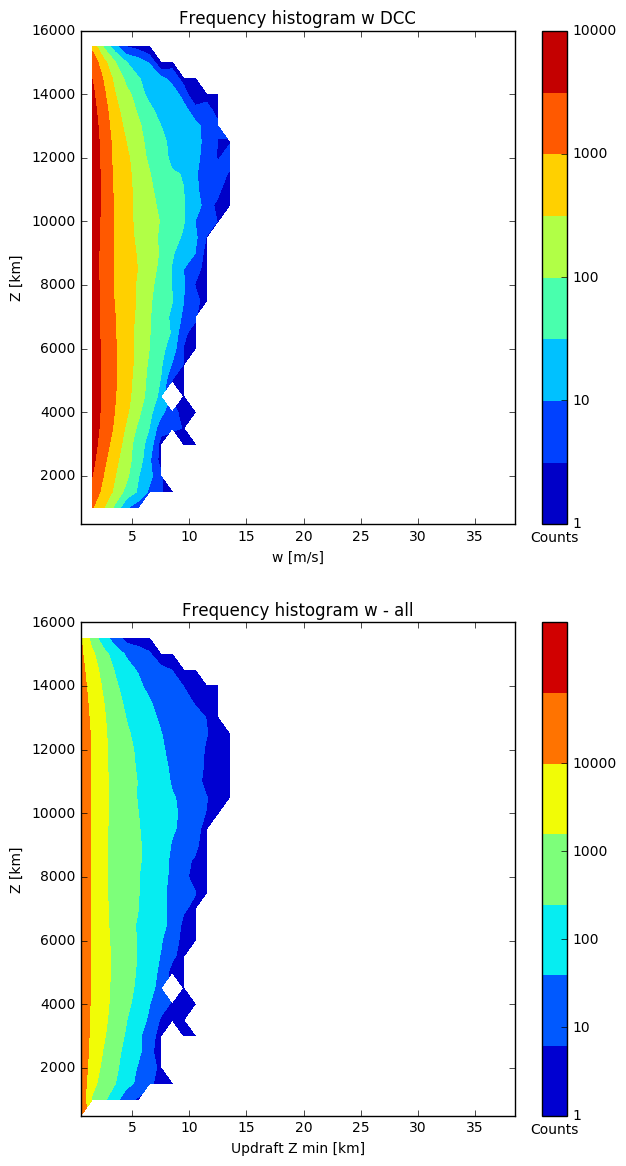

In [216]:
Y = z_levels
X = (bins[1:]+bins[0:-1])/2

XX, YY = np.meshgrid(X,Y)
plt.figure(figsize=(7,14))
plt.subplot(211)

plt.contourf(XX, YY, np.log10(w_hist))
ax = plt.colorbar(ticks=[0,1,2,3,4])
ax.ax.set_yticklabels(['1', '10', '100', '1000', '10000']) 
ax.ax.set_xlabel('Counts')
plt.xlabel('w [m/s]')
plt.ylabel('Z [km]')
plt.title('Frequency histogram w DCC')

plt.subplot(212)
X = (bins[1:]+bins[0:-1])/2
XX, YY = np.meshgrid(X,Y)
print(w_hist.shape)
plt.contourf(XX, YY, np.log10(w_hist_all))
ax = plt.colorbar(ticks=[0,1,2,3,4])
ax.ax.set_yticklabels(['1', '10', '100', '1000', '10000']) 
ax.ax.set_xlabel('Counts')
plt.xlabel('Updraft Z min [km]')
plt.ylabel('Z [km]')
plt.title('Frequency histogram w - all')

## Display vertical velocity PDF

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


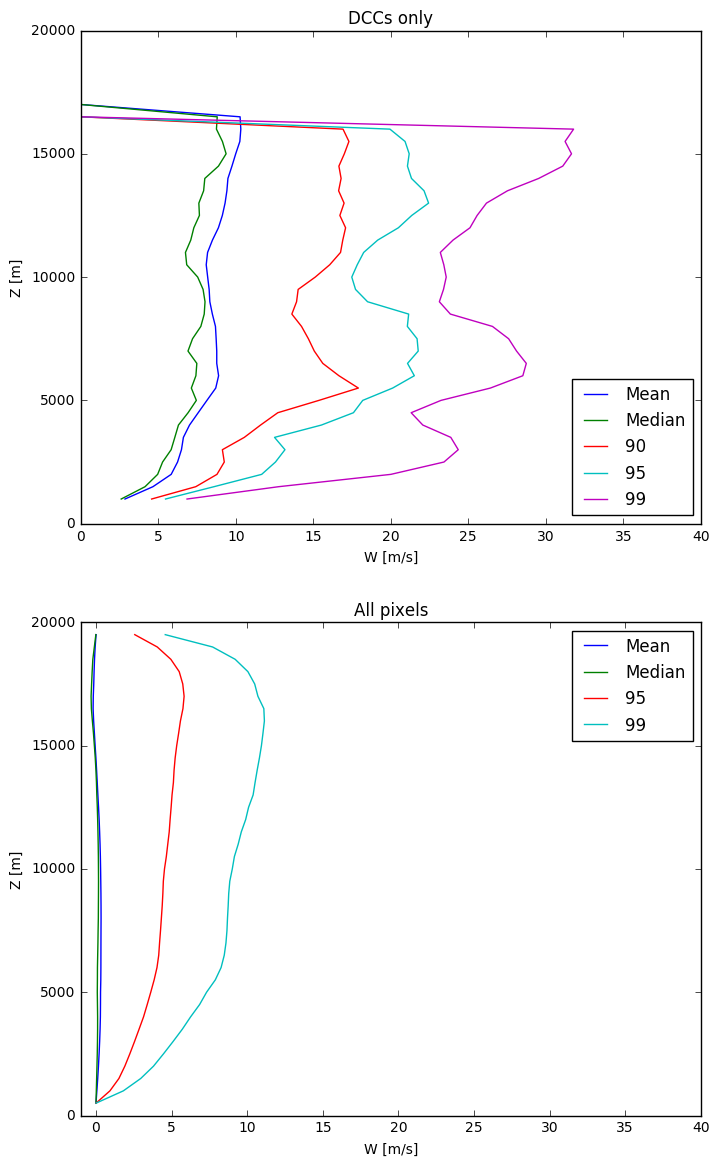

In [323]:
plt.figure(figsize=(8,14))
plt.subplot(211)
h1 = plt.plot(mean_w, z_levels, label="Median")
h2 = plt.plot(median_w, z_levels, label="Mean")
h3 = plt.plot(ninety_w, z_levels, label="90")
h4 = plt.plot(ninety_five_w, z_levels, label="95")
h5 = plt.plot(ninety_nine_w, z_levels, label="99")
plt.xlabel('W [m/s]')
plt.ylabel('Z [m]')
plt.legend(['Mean', 'Median', '90', '95', '99'], loc='best')
plt.xlim((0,40))
#plt.gca().invert_yaxis()
plt.title('DCCs only')

mean_w_all = np.ma.zeros(num_levels)
median_w_all = np.ma.zeros(num_levels)
max_w_all = np.ma.zeros(num_levels)
ninety_all = np.ma.zeros(num_levels)
ninety_five_w_all = np.ma.zeros(num_levels)
ninety_nine_w_all = np.ma.zeros(num_levels)

for levels in range(0,num_levels):
    w_level = ws_all[:,levels,:,:]
    #for i in range(0, dims[0]):
    #    w_level[i,:,:] = np.ma.masked_where(np.logical_or(dc[i,:,:] < 10, r_level[i,:,:] < 10)
    #                                        ,w_level[i,:,:])
    
    ws_in_core = w_level[~w_level.mask]
    mean_w_all[levels] = np.ma.mean(ws_in_core)
    median_w_all[levels] = np.ma.median(ws_in_core)
    
    if(len(ws_in_core) > 0):
        ninety_five_w_all[levels] = np.percentile(ws_in_core, 95)
        ninety_nine_w_all[levels] = np.percentile(ws_in_core, 99)
    else:
        ninety_five_w_all[levels] = float('nan')
        ninety_nine_w_all[levels] = float('nan')
        
plt.subplot(212)
h1 = plt.plot(mean_w_all, z_levels, label="Median")
h2 = plt.plot(median_w_all, z_levels, label="Mean")
h3 = plt.plot(ninety_five_w_all, z_levels, label="95")
h4 = plt.plot(ninety_nine_w_all, z_levels, label="99")
plt.xlabel('W [m/s]')
plt.ylabel('Z [m]')
plt.legend(['Mean', 'Median', '95', '99'], loc='best')
plt.xlim((-1,40))
#plt.gca().invert_yaxis()
plt.title('All pixels')

## Compare vertical velocity PDF versus Varble et al. (2014)

[   500.           1000.           1500.00024414   2000.           2500.
   3000.00048828   3500.00048828   4000.           4500.           5000.
   5500.00097656   6000.00097656   6500.00097656   7000.00097656
   7500.00097656   8000.           8500.           9000.           9500.
  10000.          10500.00195312  11000.00195312  11500.00195312
  12000.00195312  12500.00195312  13000.00195312  13500.00195312
  14000.00195312  14500.00195312  15000.00195312  15500.00195312  16000.
  16500.          17000.          17500.          18000.          18500.
  19000.        ]
[  1000.   1500.   2000.   2500.   3000.   3500.   4000.   4500.   5000.
   5500.   6000.   6500.   7000.   7500.   8000.   8500.   9000.   9500.
  10000.  10500.  11000.  11500.  12000.  12500.  13000.  13500.  14000.
  14500.  15000.  15500.  16000.  16500.  17000.  17500.  18000.  18500.
  19000.]


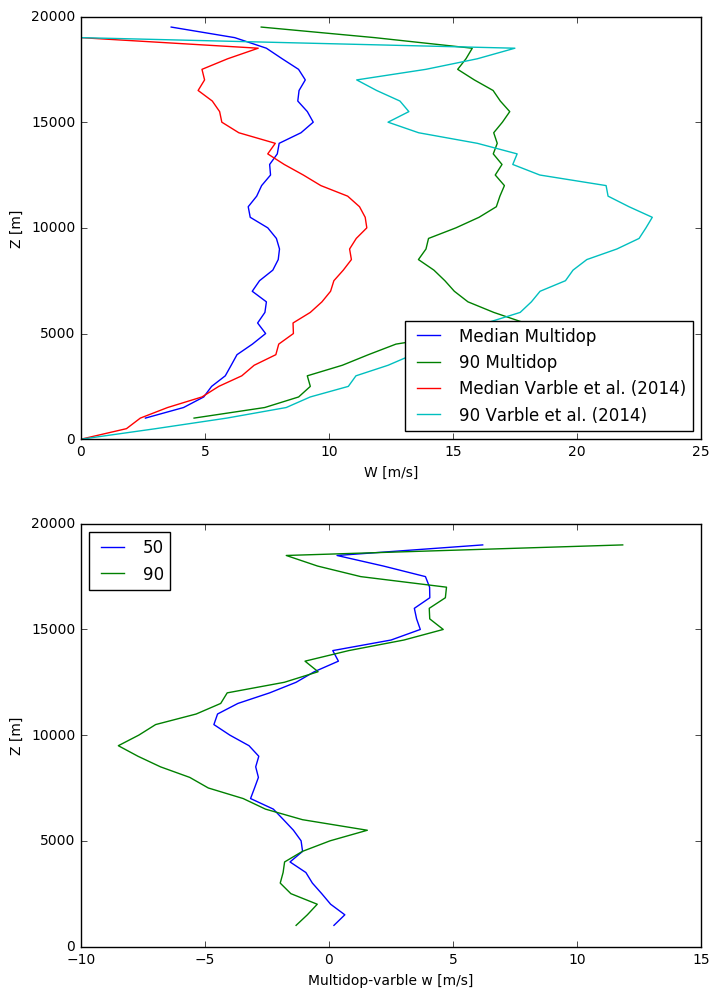

In [349]:
varble_cdf = Dataset('/home/rjackson/data/Deep_Updraft_50-90Percent_Max_W_Profiles.20060123.1310-1750Z.nc', mode='r')

z_varble = varble_cdf.variables['z'][:]
w50_varble = varble_cdf.variables['w50'][:]
w90_varble = varble_cdf.variables['w90'][:]
plt.figure(figsize=(8,12))
plt.subplot(211)
h2 = plt.plot(median_w, z_levels, label="Mean")
h3 = plt.plot(ninety_w, z_levels, label="90")
h4 = plt.plot(w50_varble, z_varble, label="95")
h5 = plt.plot(w90_varble, z_varble, label="99")
plt.xlabel('W [m/s]')
plt.ylabel('Z [m]')
plt.legend(['Median Multidop', 
            '90 Multidop', 
            'Median Varble et al. (2014)', 
            '90 Varble et al. (2014)'], loc='best')
print(z_varble[1:])
print(z_levels[1:-2])
plt.subplot(212)
h2 = plt.plot(median_w[0:-2]-w50_varble[1:], z_levels[0:-2], label="Mean")
h3 = plt.plot(ninety_w[0:-2]-w90_varble[1:], z_levels[0:-2], label="90")
plt.xlabel('Multidop-varble w [m/s]')
plt.ylabel('Z [m]')
plt.legend(['50', 
            '90'], loc='best')



## Reflectivity vertical profile

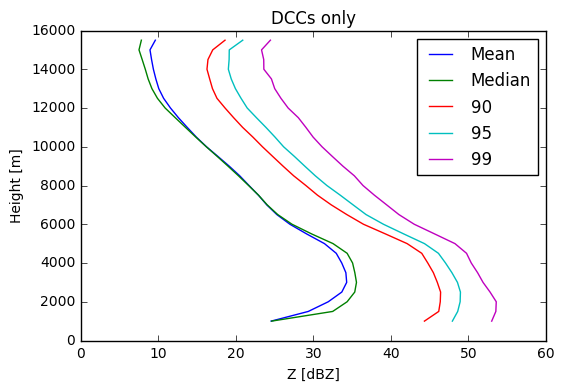

In [218]:
h1 = plt.plot(mean_z, z_levels, label="Median")
h2 = plt.plot(median_z, z_levels, label="Mean")
h3 = plt.plot(ninety_z, z_levels, label="90")
h4 = plt.plot(ninety_five_z, z_levels, label="95")
h5 = plt.plot(ninety_nine_z, z_levels, label="99")
plt.xlabel('Z [dBZ]')
plt.ylabel('Height [m]')
plt.legend(['Mean', 'Median', '90', '95', '99'], loc='best')
plt.xlim((0,60))
#plt.gca().invert_yaxis()
plt.title('DCCs only')

## Reflectivity and velocity CFAD

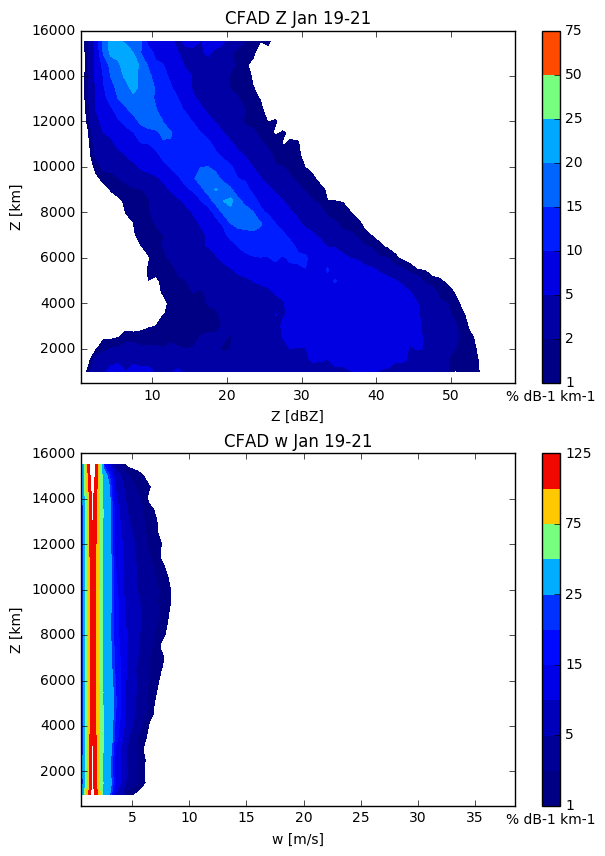

In [219]:
Y = z_levels
X = (bins_z[1:]+bins_z[0:-1])/2

XX, YY = np.meshgrid(X,Y)
plt.figure(figsize=(7,10))
plt.subplot(211)
plt.contourf(XX, YY, z_hist*100, levels=[1,2,5,10,15,20,25,50,75])
ax = plt.colorbar()
#ax.ax.set_yticklabels(['1', '10', '100', '1000', '10000']) 
ax.ax.set_xlabel('% dB-1 km-1')
plt.xlabel('Z [dBZ]')
plt.ylabel('Z [km]')
plt.title('CFAD Z Jan 19-21')

plt.subplot(212)
X = (bins[1:]+bins[0:-1])/2
XX, YY = np.meshgrid(X,Y)
plt.contourf(XX, YY, w_cfad*100, levels=[1,2,5,10,15,20,25,50,75,100,125])
ax = plt.colorbar()
#ax.ax.set_yticklabels(['1', '10', '100', '1000', '10000']) 
ax.ax.set_xlabel('% dB-1 km-1')
plt.xlabel('w [m/s]')
plt.ylabel('Z [km]')
plt.title('CFAD w Jan 19-21')

## Integrate mass flux

Calculate mass flux as a function of height by integrating w over the area covered by the storm.

Uses Grinnell et al 1996 to calculate mass flux as a function of time

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater


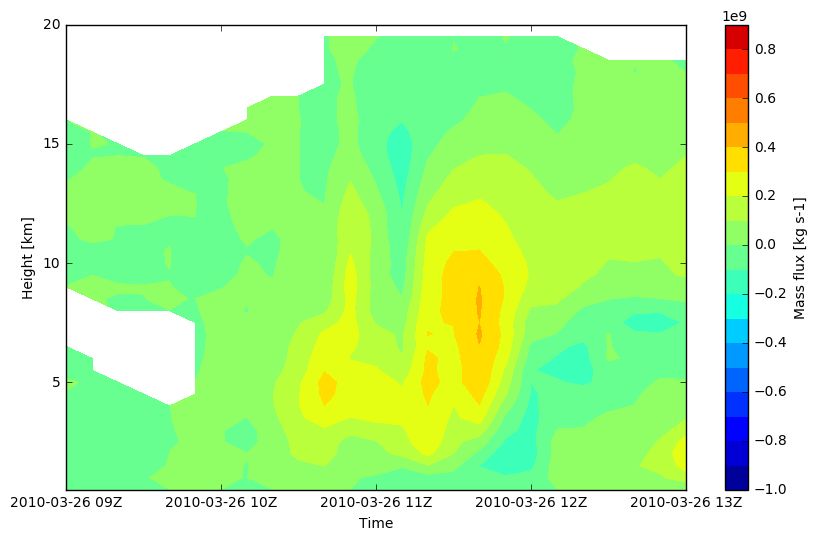

In [310]:
count = 0
num_levels = 40
dc = np.ma.zeros((len(times), 81, 111))
ws = np.ma.zeros((len(times), num_levels, 81, 111))
ws_all = np.ma.zeros((len(times), num_levels, 81, 111))
rfs = np.ma.zeros((len(times), num_levels, 81, 111))
flux = np.ma.zeros((len(times), num_levels))
datenums = []

for time in times:
    pyart_grid = get_grid_from_dda(time)
    bca = get_bca(pyart_grid)
    w = pyart_grid.fields['upward_air_velocity']['data']
    updraft_depth = np.zeros(w[0].shape)
    z = pyart_grid.fields['reflectivity']['data']
    for i in range(0,num_levels):
        ws = np.ma.masked_where(np.logical_or(np.logical_or(bca < math.pi/6,
                                                            bca > 5*math.pi/6), 
                                              z[i] < 1), w[i])
        # Grid spacing in horizontal is 1 km by 1 km, rho from Grinnell et al 1996
        rho = 1.0*np.exp(-0.5*i/8)
        flux[count,i] = rho*np.ma.sum(ws*1e3*1e3)
    count = count + 1
    datenums.append(dates.date2num(time))
    
datelocs = times[0::int(len(datenums)/4)]
x_ticks = dates.date2num(datelocs)
plt.figure(figsize=(10,6))
x,y = np.meshgrid(datenums,0.5*np.arange(1,num_levels+1))
plt.contourf(x,y,np.transpose(flux), levels=np.arange(-1e9,1e9,1e8),vmin=-1e9, vmax=1e9)
bar = plt.colorbar()
plt.clim((-1e9, 1e9))
bar.set_label('Mass flux [kg s-1]')
plt.gca().set_xticks(x_ticks)
plt.xlabel('Time')
plt.ylabel('Height [km]')
from datetime import date
# Set the xtick labels to correspond to just the dates you entered.
plt.gca().set_xticklabels([date.strftime("%Y-%m-%d %HZ") for date in datelocs])